In [394]:
from langchain_openai import OpenAIEmbeddings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from langchain_text_splitters import TokenTextSplitter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
import json

# Load the environment variables
load_dotenv()

True

# Load the data

In [395]:
train_directory = "train/train"
test_directory = "test/test"
# loader = DirectoryLoader(directory, glob='**/*.json', show_progress=True, loader_cls=TextLoader)
# data_full_text = loader.load()
# len(data_full_text)

def get_data_list(directory):
    data_full_text = []
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as json_file:
                data = json.load(json_file)
                if data:
                    ocr_texts = [str(ocr['text']) for ocr in data['0']['ocr']]
                    concatenated_text = '\n'.join(ocr_texts)
                    data_full_text.append({"source": filename, "text": concatenated_text})
                else:
                    print(f"File {filename} is empty")
    return data_full_text


In [396]:
train_text = get_data_list(train_directory)
test_text = get_data_list(test_directory)

File 1e2b7953be7636ba815864fadc095e1e.pdf.CACHE.json is empty
File 0956af3ce4abc3a87a76b8a36901de4d.pdf.CACHE.json is empty
File 145a525ff411c5447d9ed585c2409e74.pdf.CACHE.json is empty
File 248c4da26eb1bdc419058d104fc02e51.JPG.CACHE.json is empty
File 208c74fd9000ce0678ef0ae481ce7aaa.pdf.CACHE.json is empty
File 088c1bfd401dfd81480ce0c857aee199.pdf.CACHE.json is empty
File 1f6968f4cc9e2d0b41c86645711782c4.jpg.CACHE.json is empty
File 1fe28d53546729bf195cc4b0d1d19c14.JPG.CACHE.json is empty


In [397]:
def get_text_chunks(text):
    text_splitter = TokenTextSplitter(chunk_size=1200, chunk_overlap=0)
    texts = text_splitter.split_text(text)
    return texts[0]

# Find the embeddings for the documents

In [398]:
def get_embeddings(text_data):
    embeddings = OpenAIEmbeddings()
    data_text = [x['text'].lower() for x in text_data]
    vectors = embeddings.embed_documents(data_text)
    return vectors

train_embeddings = get_embeddings(train_text)
test_embeddings = get_embeddings(test_text)
len(train_embeddings)
len(test_embeddings)

280

# Apply KMeans clustering

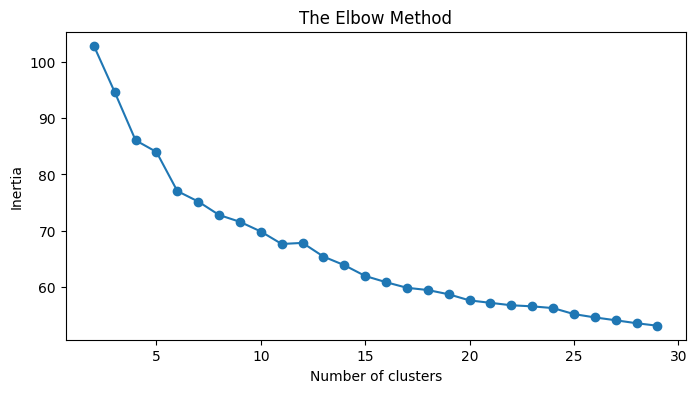

In [420]:
from sklearn import preprocessing
# Applying KMeans clustering on cleaned data with range of clusters
inertia = []

# Initialize lists to store silhouette scores
silhouette_scores = [0] * 30
range_n_clusters = list(range(2, 30))
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(preprocessing.normalize(train_embeddings))
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(train_embeddings, kmeans.labels_)
    silhouette_scores[k] = silhouette_avg

plt.figure(figsize=(8, 4))
plt.plot(range(2, 30), inertia, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

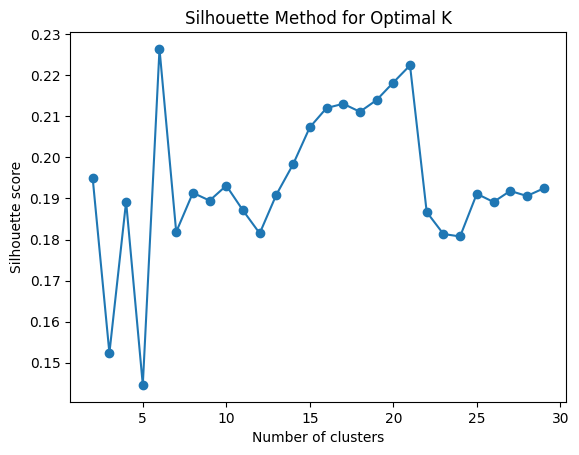

In [421]:
# Plot silhouette scores
silhouette_scores = silhouette_scores[2:30]
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method for Optimal K')
plt.show()

# From the above graph, we can see that the elbow is at 17. So, we will use 17 clusters for our KMeans clustering

In [422]:
# Applying KMeans clustering on cleaned data with 8 clusters
k_optimal = 17
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=2).fit(preprocessing.normalize(train_embeddings))

In [423]:
test_labels = kmeans_optimal.predict(preprocessing.normalize(test_embeddings))

# Processing the data

In [429]:
import pandas as pd
import os
for i, row in enumerate(test_text):
    index = row['source'].find(".")
    print(test_text[i]['source'])
    test_text[i]['source'] = row['source'][:index+1]
    print(test_text[i]['source'])
df = pd.DataFrame(os.path.basename(row['source']) for row in test_text)
df['label']=test_labels
df

dcc4a106ec167c5624a2b25430f04

e0abc9a25ac589aedafbbb26ec5ec

25a7a30c448e90fe7a74a8cf63d9c

e2620553c53f7636ed76c4f45d9a6

57ab20f06d415a76b461cc120006c

44c71bf12711a784d99a2ab2a2968

ef10fc8b264be83ec52bed6a2422d

59fb71f178f247523719897bb6127

56f44e496f67769a69bed6500fd7f

412e0942006af3c01d8ea8a9ba481

aa87d3aecf507f0f1e13a00b8b574

21ce753349be82d5c1c4ff26057f6

4072108702e781154aac5cf7895b6

d4bb59de624ba8c6eb8a25dff75a5

ae51f6126868d4b2752b9410c15a6

8fb0d020110d20a7f82ae6706cec7

20304706a6decc1775f69f7c00786

85d67c2470a99e9921dd451b9c524

edd1c44aeeccb8fb3efd7991c0c5c

a719fc8b94ec3e59e250c08128a4f

9ab7c55375f7b22ee50a73cc2fb7b

0be71a800166e8a60a3791102c558

c0aa2754ff1fdbcb688ba36b6003a

24b6eb215bac4eef4954d24ed6d21

fec330f839de21a2f3bc7ba0729b5

cf4aee18dc031ae0c7a493fd9b63a

ce2d7e0e90c61baaf5d31de0816ce

16ea433c44685375231fa7a488670

a03d9dde336944f4ba58a9038c42f

8249d4a55e1ebc289a22225fe6490

e702cb206f3e62c7c225a85b4819f

751debc083a0566ae52c7084acb07

28593a7a

,0,label
0,,3
1,,14
2,,6
3,,15
4,,4
...,...,...
275,,6
276,,4
277,,15
278,,16


In [425]:
result = {
    "clusters": {},
    "samples": {}
}

In [426]:
for index in range(k_optimal):
    result["clusters"]["cluster_" + str(index)] = "Cluster " + str(index)
for index, row in df.iterrows():
    result["samples"][row[0]] = "cluster_" + str(row['label'])
result

{'clusters': {'cluster_0': 'Cluster 0',
  'cluster_1': 'Cluster 1',
  'cluster_2': 'Cluster 2',
  'cluster_3': 'Cluster 3',
  'cluster_4': 'Cluster 4',
  'cluster_5': 'Cluster 5',
  'cluster_6': 'Cluster 6',
  'cluster_7': 'Cluster 7',
  'cluster_8': 'Cluster 8',
  'cluster_9': 'Cluster 9',
  'cluster_10': 'Cluster 10',
  'cluster_11': 'Cluster 11',
  'cluster_12': 'Cluster 12',
  'cluster_13': 'Cluster 13',
  'cluster_14': 'Cluster 14',
  'cluster_15': 'Cluster 15',
  'cluster_16': 'Cluster 16'},
 'samples': {'dcc4a106ec167c5624a2b25430f042': 'cluster_3',
  'e0abc9a25ac589aedafbbb26ec5ece': 'cluster_14',
  '25a7a30c448e90fe7a74a8cf63d9c9': 'cluster_6',
  'e2620553c53f7636ed76c4f45d9a67': 'cluster_15',
  '57ab20f06d415a76b461cc120006cd': 'cluster_4',
  '44c71bf12711a784d99a2ab2a29687': 'cluster_12',
  'ef10fc8b264be83ec52bed6a2422d8': 'cluster_1',
  '59fb71f178f247523719897bb6127a': 'cluster_6',
  '56f44e496f67769a69bed6500fd7f6': 'cluster_5',
  '412e0942006af3c01d8ea8a9ba4812': 'clust

In [427]:
import json
file_path = "test_results.json"

# Write dictionary to JSON file
with open(file_path, "w") as json_file:
    json.dump(result, json_file, indent=4)

print(f"Dictionary saved to {file_path}")

Dictionary saved to test_results.json


In [419]:
len(result['samples'])

280

In [227]:
# loader = JSONLoader(
#     file_path='test.json',
#     jq_schema=".ocr[].text",
#     text_content=False)
#
# data = loader.load()
# print(f'document count: {len(data)}')
# data

In [10]:
# # Load the vectorstore
# faiss_index = FAISS.from_documents(data_full_text, embeddings)
# faiss_index.save_local("faiss_index")
# faiss_db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

In [11]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
#
# # Taking out the warnings
# import warnings
# from warnings import simplefilter
#
# # Filter out FutureWarnings
# simplefilter(action='ignore', category=FutureWarning)
#
# # Perform t-SNE and reduce to 2 dimensions
# tsne = TSNE(n_components=2, random_state=42)
# reduced_data_tsne = tsne.fit_transform(vectors)
#
# # Plot the reduced data
# plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.title('Book Embeddings Clustered')
# plt.show()